In [1]:
using LsqFit
using PyPlot

include("ttv_wrapper_fixp3.jl")
include("ttv_nplanet.jl")

# Read in transit times
TT_1 = readdlm("ttv_planet1.txt")[:]
TT_2 = readdlm("ttv_planet2.txt")[:]
transit_times = [TT_1; TT_2];

In [2]:
# Functions
function ttv_model2(x, params)
   res = ttv_nplanet(2, 5, [length(TT_1), length(TT_2)], params)
   return [add_linear(res[1,:], params[3], params[2]); add_linear(res[2, :][1:length(TT_2)], params[8], params[7])]
end

function fit_ttv2(params)
   transit_time_fit   = curve_fit(ttv_model2, 0, [TT_1; TT_2], params)
   transit_time_model = ttv_model2(0, transit_time_fit.param)
   return transit_time_model, transit_time_fit
end

function add_linear(x, initial, period)
   return x + (collect(eachindex(x))-1)*period + initial
end

function fit_ttv3_fixed(params)
   res = curve_fit(ttv_wrapper_fixp3, 0, [TT_1; TT_2], params)
   return res
end

function log_likelihood(obs, mean, err)
    return sum(-0.5*((obs - mean).^2)./(err.^2))
end

function PrintPlanet(Planet)
  print(string("Orbital parameters from TTV fitting for planet ", Planet["Name"],":\n"))
  print(string("  Period: ", Planet["Period"],"\n"))
  print(string("  Mass Ratio: ", Planet["MassRatio"],"\n"))
  print(string("  Transit Time t0: ", abs(Planet["Trans0"]%Planet["Period"]),"\n"))
  print(string("  ecos(w): ", Planet["ecosw"],"\n"))
  print(string("  esin(w): ", Planet["esinw"],"\n"))
end

PrintPlanet (generic function with 1 method)

In [3]:
# Find the period
period_1 = mean(TT_1[2:end]-TT_1[1:end-1])
period_2 = mean(TT_2[2:end]-TT_2[1:end-1])

# Initialize Parameters
# stellar mass ratio, planet period, center of transit time, eccentricity vectors (cos/sin)
# mass ratio, period, t_0, ecosomega, esinomega
init_1 = vec([2.e-5,period_1,TT_1[1],0.001,0.001])
init_2 = vec([3.e-5,period_2,TT_2[1],0.001,0.001])
init = [init_1;init_2]

# Fit two planet model
two_planet_model, two_planet_fit = fit_ttv2(init)
println(two_planet_fit.param)

# Fit three planet model (with two planet mode results)
n_periods = 10 #1000
periods   = collect(linspace(4300,4400,n_periods))
n_phases  = 10 #20
phases    = collect(linspace(0,2*pi,n_phases))
n_ecc     = 10 #20
ecc       = collect(logspace(-4,-1,n_ecc))

likelihood = zeros(n_periods,n_phases,n_ecc)
for i = 1:n_periods 
    global p3_cur = periods[i]
    for j = 1:n_phases 
        for k = 1:n_ecc
            global ecos = ecc[k]*cos(phases[j])
            global esin = ecc[k]*sin(phases[j])
            params = [two_planet_fit.param; [1e-3, TT_1[1]]]
            three_planet_fit   = fit_ttv3_fixed(params)
            three_planet_model = ttv_wrapper_fixp3(0, params[1:end])  # TTVs corresp. to our fit
            likelihood[i,j,k]  = log_likelihood(three_planet_model,transit_times,1) 
        end
    end
end


[2

$\textbf{Note:}$ While we realize we would like to run these for larger values (periods,phases,ecc: 1000,20,20), due to time constraints we have not run them for these values.

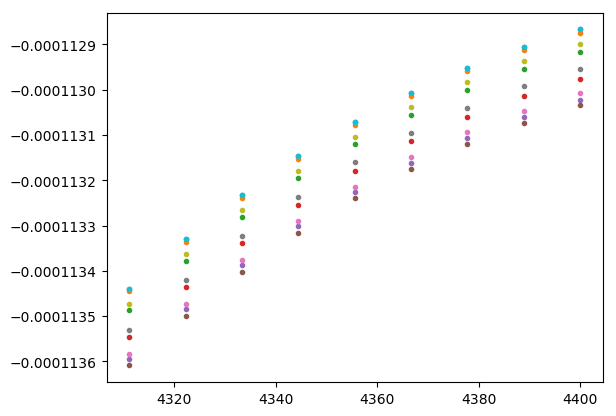

In [4]:
plot(periods[2:end],likelihood[2:end,:,1], ".")
print(" ")

In [5]:
Planet1 = Dict("MassRatio"=>0., "Period"=>0., "Trans0"=>0., "ecosw"=>0., "esinw"=>0., "Name"=>"Venus");
Planet1["MassRatio"] = two_planet_fit.param[1];
Planet1["Period"]    = two_planet_fit.param[2];
Planet1["Trans0"]    = two_planet_fit.param[3];
Planet1["ecosw"]     = two_planet_fit.param[4];
Planet1["esinw"]     = two_planet_fit.param[5];

PrintPlanet(Planet1)

Orbital parameters from TTV fitting for planet Venus:
  Period: 224.70077066767394
  Mass Ratio: 2.2532714624716408e-6
  Transit Time t0: 131.571003092962
  ecos(w): 0.009322790190626795
  esin(w): 0.003055050918457423


In [6]:
Planet2 = Dict("MassRatio"=>0., "Period"=>0., "Trans0"=>0., "ecosw"=>0., "esinw"=>0., "Name"=>"Earth");
Planet2["MassRatio"] = two_planet_fit.param[6];
Planet2["Period"]    = two_planet_fit.param[7];
Planet2["Trans0"]    = two_planet_fit.param[8];
Planet2["ecosw"]     = two_planet_fit.param[9];
Planet2["esinw"]     = two_planet_fit.param[10];

PrintPlanet(Planet2)

Orbital parameters from TTV fitting for planet Earth:
  Period: 365.2563627558245
  Mass Ratio: 3.136154732823626e-6
  Transit Time t0: 60.86284207857693
  ecos(w): 0.021151327560949264
  esin(w): 0.006036417454054439


1) Do you have a recommendation for an MCMC package in Julia? We found a few that were complicated and appeard to be written for purposes very different than ours. Is there something like emcee for Julia? Anyway, we failed to run a Markov chain on our fit.

2) These planets are Venus, Earth, and Jupiter. The implication is that the transit timings of Earth cannot be explained by its interaction with Venus alone. We have to add Jupiter to accurately model Earth's transit timings. For Venus the addition of Jupiter is less important. Also, it seems that we're able to fit for Earth's transit times just fine without including Mars, because of its low mass.